#**Download Libraries**

In [1]:
# pip install gym stable-baselines3 yfinance
# pip install --upgrade "shimmy>=2.0"
# pip install --upgrade "stable-baselines3[extra]" "gymnasium" "shimmy" "torch
# pip install gymnasium
# pip cache purge
# pip install stable-baselines3[extra]
# pip install shimmy
# pip install yfinance gym stable-baselines3 matplotlib pandas
# pip install yfinance gym stable-baselines3 matplotlib pandas yfinance shimmy
# pip install alpha_vantage
# pip install stable-baselines3[extra] sb3-contrib



#**Fetch Data using Yahoo Finance**

In [2]:
'''
import yfinance as yf
import pandas as pd
from datetime import datetime

# Define the stock tickers and the period for which you want the data
tickers = ['AAPL', 'MSFT', 'GOOG', 'KO', 'PG', 'F', 'GE', 'T', 'XOM', 'CSCO', 'JNJ']
start_date = '2019-01-01'
end_date = '2023-12-31'
data = {}

# Fetch data for each ticker
for ticker in tickers:
    try:
        stock_data = yf.download(ticker, start=start_date, end=end_date)
        data[ticker] = stock_data
    except Exception as e:
        print(f"Error fetching data for {ticker}: {e}")

# Convert the data into a DataFrame
if data:
    stock_data = pd.concat(data, axis=1)
    stock_data.to_csv("yfinance_stock_data.csv")
    print(stock_data.head())
else:
    print("No data fetched.")
'''

'\nimport yfinance as yf\nimport pandas as pd\nfrom datetime import datetime\n\n# Define the stock tickers and the period for which you want the data\ntickers = [\'AAPL\', \'MSFT\', \'GOOG\', \'KO\', \'PG\', \'F\', \'GE\', \'T\', \'XOM\', \'CSCO\', \'JNJ\']\nstart_date = \'2019-01-01\'\nend_date = \'2023-12-31\'\ndata = {}\n\n# Fetch data for each ticker\nfor ticker in tickers:\n    try:\n        stock_data = yf.download(ticker, start=start_date, end=end_date)\n        data[ticker] = stock_data\n    except Exception as e:\n        print(f"Error fetching data for {ticker}: {e}")\n\n# Convert the data into a DataFrame\nif data:\n    stock_data = pd.concat(data, axis=1)\n    stock_data.to_csv("yfinance_stock_data.csv")\n    print(stock_data.head())\nelse:\n    print("No data fetched.")\n'

In [3]:
import pandas as pd

#stock_data = pd.read_csv("stock_data_1990_2024.csv", header=[0, 1, 2], index_col=0, parse_dates=True)
stock_data = pd.read_csv("etfs_data_2010_2024.csv", header=[0, 1, 2], index_col=0, parse_dates=True)

stock_data.head()

SPY                                                    IVV  \
Price           Close       High        Low       Open     Volume      Close   
Ticker            SPY        SPY        SPY        SPY        SPY        IVV   
Date                                                                           
2010-01-04  85.768448  85.813854  84.391067  85.041918  118944600  85.936852   
2010-01-05  85.995506  86.033349  85.405201  85.715493  111579900  86.186386   
2010-01-06  86.056046  86.267949  85.844142  85.912251  116074400  86.254448   
2010-01-07  86.419312  86.525263  85.654939  85.897116  131091100  86.632530   
2010-01-08  86.706871  86.744713  86.018184  86.192245  126402800  86.927437   

                                                      ...        EMB  \
Price            High        Low       Open   Volume  ...      Close   
Ticker            IVV        IVV        IVV      IVV  ...        EMB   
Date                                                  ...              
2010-01-04  86.004903  85.226065  85.271433  3574200  ...  49.949966   
2010-01-05  86.224190  85.634391  85.914170  2784100  ...  50.253784   
2010-01-06  86.458607  86.042726  86.118340  3912800  ...  50.322403   
2010-01-07  86.708144  85.861256  86.103225  2977600  ...  50.062679   
2010-01-08  86.935000  86.209093  86.375448  2887600  ...  50.121517   

                                                           VOE             \
Price            High        Low       Open  Volume      Close       High   
Ticker            EMB        EMB        EMB     EMB        VOE        VOE   
Date                                                                        
2010-01-04  49.949966  49.655942  49.856857  120500  32.666763  32.724810   
2010-01-05  50.268485  50.018562  50.087168   98700  32.768356  32.775611   
2010-01-06  50.351804  50.096984  50.278297  135300  33.000546  33.007803   
2010-01-07  50.234193  50.033274  50.170485   98300  33.239983  33.261750   
2010-01-08  50.224426  50.072514  50.121517  327900  33.348839  33.348839   

                                          
Price             Low       Open  Volume  
Ticker            VOE        VOE     VOE  
Date                                      
2010-01-04  32.449082  32.507129  143700  
2010-01-05  32.536163  32.674027  156100  
2010-01-06  32.753839  32.753839  172600  
2010-01-07  32.811875  32.956994   84800  
2010-01-08  33.087620  33.152925   70400  

[5 rows x 380 columns]

# **Trading Environment**

In [4]:
import gym
from gym import spaces
import numpy as np
import pandas as pd

# Constants for tax rates and holding period
SHORT_TERM_TAX_RATE = 0.20
LONG_TERM_TAX_RATE = 0.15
HOLDING_PERIOD_THRESHOLD = 365

class StockTradingEnv(gym.Env):
    def __init__(self, stock_data, initial_balance=10000, max_trade_pct=0.1, transaction_cost=0.001):
        super().__init__()
        
        # Store Stock Data as a numpy array
        if isinstance(stock_data, pd.DataFrame):
            self.original_df = stock_data  # Keep original DataFrame for ticker info and dates
            
            # Extract tickers with better handling of column names
            try:
                # Look at the first elements of column names (for tuples) or split string names
                self.stock_tickers = []
                for col in stock_data.columns[::5]:
                    if isinstance(col, tuple):
                        # Extract first element of tuple if it's a tuple
                        self.stock_tickers.append(col[0])
                    else:
                        # Otherwise split by underscore and take first part
                        self.stock_tickers.append(str(col).split('_')[0])
            except (AttributeError, IndexError):
                # Fallback to generic names
                self.stock_tickers = [f"Stock_{i}" for i in range(len(stock_data.columns) // 5)]
                
            # Store dates or create numeric indices
            self.dates = stock_data.index if hasattr(stock_data, 'index') else np.arange(len(stock_data))
            self.stock_data = stock_data.values
        else:
            raise ValueError("stock_data must be a pandas DataFrame")

        '''if not isinstance(stock_data, pd.DataFrame):
            raise ValueError("stock_data must be a pandas DataFrame")

        self.original_df = stock_data
        self.stock_tickers = [str(col).split('_')[0] for col in stock_data.columns[::5]]
        self.dates = stock_data.index
        self.stock_data = stock_data.values'''

        self.n_steps = len(stock_data)
        self.n_stocks = len(stock_data.columns) // 5
        self.current_step = 0

        self.action_space = spaces.MultiDiscrete([3] * self.n_stocks)
        self.observation_space = spaces.Box(low=0, high=np.inf, shape=(len(stock_data.columns),), dtype=np.float32)

        self.initial_balance = initial_balance
        self.max_trade_pct = max_trade_pct
        self.transaction_cost = transaction_cost

        self.reset()

    # Reset the environment to its initial state
    # Added portfolio value to the reset function
    def reset(self):
        self.current_step = 0
        self.current_balance = self.initial_balance
        self.current_portfolio = np.zeros(self.n_stocks)
        self.stock_purchase_prices = np.zeros(self.n_stocks)
        self.stock_purchase_times = np.zeros(self.n_stocks)
        self.total_trades = 0
        self.stock_profit = np.zeros(self.n_stocks)
        self.trade_logs = []
        self.post_trade_log = []
        self.portfolio_history = [self.initial_balance]
        return self._get_observation()

    # Step function to execute the action and return the next state, reward, and done flag
    # Added portfolio value to the step function
    def step(self, action):
        if self.current_step >= self.n_steps - 1:
            return self._get_observation(), 0, True, {}

        self._execute_trades(action)
        self.current_step += 1
        total_value = self._get_total_value()
        self.portfolio_history.append(total_value)
        reward = self._calculate_reward(total_value)
        done = self.current_step >= self.n_steps - 1
        return self._get_observation(), reward, done, {}

    # Get the current observation (stock prices and portfolio value)
    # Added portfolio value to the observation
    def _get_observation(self):
        return np.array(self.stock_data[self.current_step], dtype=np.float32)

    # Calculate the total value of the portfolio
    # Added portfolio value to the total value calculation
    def _get_total_value(self):
        prices = self.stock_data[self.current_step, ::5]
        return self.current_balance + np.sum(self.current_portfolio * prices)


    # Calculate the reward based on portfolio performance and other factors
    # Added rolling Sharpe ratio, growth reward, trade penalty, and crash avoidance
    def _calculate_reward(self, total_value):
        if len(self.portfolio_history) < 5:
            self.portfolio_history = [self.initial_balance] * 5

        # Calculate profit, rolling Sharpe ratio, growth reward, trade penalty, and crash avoidance
        # --- Portfolio performance ---
        profit = (total_value - self.initial_balance) / self.initial_balance
        returns = np.diff(self.portfolio_history[-5:]) / np.array(self.portfolio_history[-5:-1])
        rolling_sharpe = np.mean(returns) / (np.std(returns) + 1e-6) if len(returns) > 0 else 0
        growth_reward = (self.portfolio_history[-1] - np.mean(self.portfolio_history[-5:])) / self.initial_balance
        trade_penalty = np.log1p(self.total_trades) * self.transaction_cost

        last_trade_profit = getattr(self, "last_trade_profit", 0)
        trade_reward = max(0, last_trade_profit / self.initial_balance)

        # --- Post-trade direction reward ---
        direction_reward = 0
        if hasattr(self, 'post_trade_log'): 
            for entry in self.post_trade_log:
                price_then = entry['Price_Then']
                price_now = entry['Price_Now']
                action_type = entry['Trade_Type']
                price_diff = price_now - price_then
                if action_type == 'buy' and price_diff > 0:
                    direction_reward += 0.05  # reward for buying before rise
                elif action_type == 'sell' and price_diff < 0:
                    direction_reward += 0.05  # reward for selling before drop
                elif action_type == 'buy' and price_diff < 0:
                    direction_reward -= 0.03  # penalty for buying before fall
                elif action_type == 'sell' and price_diff > 0:
                    direction_reward -= 0.03  # penalty for selling before rise
            self.post_trade_log = []  # clear after use

        # --- Crash avoidance reward ---
        crash_reward = 0
        if self.current_step >= 10:
            recent_prices = self.stock_data[self.current_step - 5:self.current_step, ::5].mean(axis=1)
            price_drop_pct = (recent_prices[-1] - recent_prices[0]) / recent_prices[0]
            if price_drop_pct < -0.05:  # crash threshold
                # Reward if holding mostly cash
                portfolio_value = np.sum(self.current_portfolio * self.stock_data[self.current_step, ::5])
                total = self.current_balance + portfolio_value
                cash_ratio = self.current_balance / total
                if cash_ratio > 0.7:
                    crash_reward += 0.1
                elif cash_ratio < 0.2:
                    crash_reward -= 0.1

        reward = profit \
            + 0.01 * rolling_sharpe \
            + 0.5 * growth_reward \
            + 0.5 * trade_reward \
            + direction_reward \
            + crash_reward \
            - trade_penalty

        if self.current_step < 2:
            print(f"[DEBUG] Step={self.current_step} | Profit={profit:.4f}, Sharpe={rolling_sharpe:.4f}, Growth={growth_reward:.4f}, TradeReward={trade_reward:.4f}, Dir={direction_reward:.4f}, Crash={crash_reward:.4f}, Penalty={trade_penalty:.4f}, Total Reward={reward:.4f}")

        reward = np.clip(reward, -500, 500)
        return reward


    # Execute trades based on the action taken
    # Action space: 0 = Buy, 1 = Hold, 2 = Sell
    def _execute_trades(self, action):
        prices = self.stock_data[self.current_step, ::5]
        total_value = self._get_total_value()
        max_alloc = total_value * 0.15
        max_trade_amt = self.current_balance * self.max_trade_pct

       
        for i in range(self.n_stocks):
            act = action[i]
            price = prices[i]
            
            # Skip if price is zero, negative, or NaN
            if price is None or price <= 0 or np.isnan(price):
                print(f"[WARNING] Invalid price at step {self.current_step} for stock {self.stock_tickers[i]}")
                continue  # Skip this stock this step

            # Check if the action is valid
            if act == 0:  # Buy
                trade_amt = min(max_trade_amt, max_alloc, self.current_balance)
                shares = int(trade_amt // price)
                if shares > 0:
                    self.current_balance -= shares * price * (1 + self.transaction_cost)
                    self.current_portfolio[i] += shares
                    self.stock_purchase_prices[i] = price
                    self.stock_purchase_times[i] = self.current_step
                    self.total_trades += 1
                    self._log_trade('Buy', i, shares, price)

                    # --- Post-trade price check setup ---
                    lookahead = self.current_step + 3
                    if lookahead < self.n_steps:
                        future_price = self.stock_data[lookahead, i * 5]
                        if not hasattr(self, 'post_trade_log'):
                            self.post_trade_log = []
                        self.post_trade_log.append({
                            'Trade_Type': 'buy',  # or 'sell'
                            'Ticker': self.stock_tickers[i],
                            'Price_Then': price,
                            'Price_Now': future_price,
                            'Step': self.current_step
                        })
            
            elif act == 2:  # Sell
                shares = int(self.current_portfolio[i])
                if shares > 0:
                    proceeds = shares * price * (1 - self.transaction_cost)
                    profit = shares * (price - self.stock_purchase_prices[i])
                    holding = self.current_step - self.stock_purchase_times[i]
                    tax = SHORT_TERM_TAX_RATE if holding < HOLDING_PERIOD_THRESHOLD else LONG_TERM_TAX_RATE
                    net = profit - profit * tax if profit > 0 else profit
                    self.stock_profit[i] += net
                    self.current_balance += proceeds
                    self.current_portfolio[i] -= shares
                    self.total_trades += 1
                    self._log_trade('Sell', i, shares, price, net, holding)

                    # --- Post-trade price check setup ---
                    lookahead = self.current_step + 3
                    if lookahead < self.n_steps:
                        future_price = self.stock_data[lookahead, i * 5]
                        if not hasattr(self, 'post_trade_log'):
                            self.post_trade_log = []
                        self.post_trade_log.append({
                            'Trade_Type': 'sell',  # or 'sell'
                            'Ticker': self.stock_tickers[i],
                            'Price_Then': price,
                            'Price_Now': future_price,
                            'Step': self.current_step
                        })

    # Log trades for analysis
    # Added profit/loss and holding period to the log
    def _log_trade(self, typ, idx, qty, price, profit=0, hold=0):
        self.trade_logs.append({
            'Stock_Ticker': self.stock_tickers[idx],
            'Trade_Type': typ,
            'Quantity': qty,
            'Price': price,
            'Date': self.dates[self.current_step],
            'Profit_Loss': round(profit, 2),
            'Holding_Period': hold
        })

    # Save trade logs to a CSV file
    # Added profit/loss and holding period to the log
    def save_trade_logs(self, filepath='logs.csv'):
        if not self.trade_logs:
            print("No trades to log.")
            return
        df = pd.DataFrame(self.trade_logs)
        df.to_csv(filepath, index=False)
        print(f"Trade logs saved to {filepath}")

    # Render the current state of the environment
    # Added portfolio value and total value to the render method
    def render(self):
        print(f"Step: {self.current_step}, Balance: {self.current_balance}, Portfolio Value: {np.sum(self.current_portfolio * self.stock_data[self.current_step, ::5])}, Total Value: {self.current_balance + np.sum(self.current_portfolio * self.stock_data[self.current_step, ::5])}")


# **Split Data**

In [5]:
# 80% training, 20% testing
train_size = int(len(stock_data) * 0.8)  

train_data = stock_data.iloc[:train_size]  # First 80% for training 
test_data = stock_data.iloc[train_size:]  # Remaining 20% for testing

print(f"Training data: {train_data.index[0]} to {train_data.index[-1]}")
print(f"Testing data: {test_data.index[0]} to {test_data.index[-1]}")

Training data: 2010-01-04 00:00:00 to 2021-12-29 00:00:00
Testing data: 2021-12-30 00:00:00 to 2024-12-31 00:00:00


# **Enviroment Parameters**

In [6]:
# Define fixed environment parameters
initial_balance = 20000  # Set initial capital amount
max_trade_percentage = 0.1  # Max 10% of total capital per transaction
transaction_cost = 0.005  # Transaction cost per trade
top_n_stocks=5  # Number of top-ranked stocks to trade

# **Train PPO-LSTM Model**

In [7]:
from sb3_contrib import RecurrentPPO

# Create the environment
train_env = StockTradingEnv(
    train_data, 
    initial_balance=initial_balance, 
    max_trade_pct=max_trade_percentage, 
    transaction_cost=transaction_cost
)

# Define learning rate decay as a lambda function
#decaying_lr = lambda f: 0.00005 + (0.0003 - 0.00005) * f  # decays from 0.0003 to 0.00005

# Better hyperparameters
model = RecurrentPPO(
    'MlpLstmPolicy', 
    train_env, 
    verbose=1,
    learning_rate=lambda f: 0.00005 + (0.0003 - 0.00005) * f,  # decays over training
    gamma=0.97,  # Discount factor for future rewards
    ent_coef=0.03,  # Encourage exploration
    vf_coef=0.5,    # Value function coefficient
    max_grad_norm=0.5,
    n_steps=1024,   # Longer rollout for better learning
    batch_size=128  # Larger batch size for more stable updates
)

# Define number of epochs
num_epochs = 5
# Calculate total timesteps based on data length and epochs
steps_per_epoch = len(train_data)
total_timesteps = steps_per_epoch * num_epochs


print(f"Training for {num_epochs} epochs ({total_timesteps} total timesteps)")
model.learn(total_timesteps=total_timesteps)

# Save the trained model
model.save("ppo_trained_model_lstm")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


C:\Users\tinot\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Training for 5 epochs (15095 total timesteps)
[DEBUG] Step=1 | Profit=-0.0012, Sharpe=0.0000, Growth=0.0000, TradeReward=0.0000, Dir=0.3600, Crash=0.0000, Penalty=0.0128, Total Reward=0.3460
-----------------------------
| time/              |      |
|    fps             | 51   |
|    iterations      | 1    |
|    time_elapsed    | 20   |
|    total_timesteps | 1024 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 34          |
|    iterations           | 2           |
|    time_elapsed         | 60          |
|    total_timesteps      | 2048        |
| train/                  |             |
|    approx_kl            | 0.025010077 |
|    clip_fraction        | 0.327       |
|    clip_range           | 0.2         |
|    entropy_loss         | -83.5       |
|    explained_variance   | 0.00764     |
|    learning_rate        | 0.000283    |
|    loss                 | 5.84        |
|    n_upda

# **Load and Test Model**

In [ ]:
from sb3_contrib import RecurrentPPO

# Load the saved model
model = RecurrentPPO.load("ppo_trained_model_lstm")

# Create the environment
test_env = StockTradingEnv(test_data, initial_balance=initial_balance, max_trade_pct=max_trade_percentage, transaction_cost=transaction_cost)


# **Evaluate Using All Stocks**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import pandas as pd
import seaborn as sns

def evaluate_trading_bot(model, env, benchmark_data=None, initial_investment=20000):
    obs = env.reset()
    total_rewards = []
    portfolio_values = []
    daily_returns = []
    trade_penalties = []

    for _ in range(env.n_steps):
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, _ = env.step(action)

        close_prices = obs[::5]
        total_value = env.current_balance + np.sum(env.current_portfolio * close_prices)

        portfolio_values.append(total_value)
        total_rewards.append(reward)
        trade_penalties.append(env.total_trades * env.transaction_cost)

        if len(portfolio_values) > 1:
            daily_returns.append((portfolio_values[-1] - portfolio_values[-2]) / portfolio_values[-2])

        if done:
            break

    final_value = portfolio_values[-1]
    metrics = calculate_metrics(initial_investment, final_value, daily_returns, portfolio_values, env.total_trades)

    print("\n Evaluation Metrics for Trading All Stocks:")
    for key, value in metrics.items():
        print(f"{key}: {value:.2f}")

    # Save and Reload Trade Logs
    env.save_trade_logs("trading_history.csv")
    trade_logs = pd.read_csv("trading_history.csv")

    # --- Start Plotting All Subplots ---
    fig, axs = plt.subplots(4, 2, figsize=(18, 15))
    
    # 1. Portfolio Value
    axs[0, 0].plot(portfolio_values, label='Portfolio Value', color='blue')
    axs[0, 0].set_title('Portfolio Value Over Time')
    axs[0, 0].set_xlabel('Time Step')
    axs[0, 0].set_ylabel('Value')
    axs[0, 0].legend()

    # 2. Rewards
    axs[0, 1].plot(smooth_series(total_rewards, window=20), label='Smoothed Reward', color='green')
    axs[0, 1].set_title('Smoothed Reward Over Time')
    axs[0, 1].set_title('Reward Over Time')
    axs[0, 1].set_xlabel('Time Step')
    axs[0, 1].set_ylabel('Reward')
    axs[0, 1].legend()

    # 3. Daily Returns
    axs[1, 0].plot(daily_returns, label='Daily Returns', color='purple')
    axs[1, 0].set_title('Daily Return Over Time')
    axs[1, 0].set_xlabel('Time Step')
    axs[1, 0].set_ylabel('Return')
    axs[1, 0].legend()

    # 4. Trade Penalties
    axs[1, 1].plot(trade_penalties, label='Trade Penalty', color='red')
    axs[1, 1].set_title('Trade Penalty Over Time')
    axs[1, 1].set_xlabel('Time Step')
    axs[1, 1].set_ylabel('Penalty')
    axs[1, 1].legend()

    # 5. Portfolio vs Benchmark
    if benchmark_data is not None:
        axs[2, 0].plot(portfolio_values, label='RL Portfolio')
        axs[2, 0].plot(benchmark_data, label='Benchmark (e.g., SPY)', linestyle='--')
        axs[2, 0].set_title('Portfolio vs. Benchmark')
        axs[2, 0].set_xlabel('Time Step')
        axs[2, 0].set_ylabel('Value')
        axs[2, 0].legend()
    else:
        axs[2, 0].axis('off')

    # 6. Top 5 Stocks Cumulative Profit
    if 'Stock_Ticker' in trade_logs.columns and 'Profit_Loss' in trade_logs.columns:
        top5 = trade_logs.groupby('Stock_Ticker')['Profit_Loss'].sum().sort_values(ascending=False).head(5)
        axs[2, 1].bar(top5.index, top5.values, color='orange')
        axs[2, 1].set_title('Top 5 Stocks Cumulative Profit')
        axs[2, 1].set_xlabel('Stock')
        axs[2, 1].set_ylabel('Profit')
    else:
        axs[2, 1].axis('off')
        
    
    # 7. Drawdown % Over Time
    peak = np.maximum.accumulate(portfolio_values)
    drawdowns = (peak - portfolio_values) / peak * 100
    axs[3, 0].plot(drawdowns, label='Drawdown (%)', color='orange')
    axs[3, 0].set_title('Drawdown (%) Over Time')
    axs[3, 0].set_xlabel('Time Step')
    axs[3, 0].set_ylabel('Drawdown %')
    axs[3, 0].legend()
    
    
    # 8. Rolling Sharpe Ratio
    window = 100  # Rolling window size
    daily_returns = pd.Series(daily_returns)
    rolling_mean = daily_returns.rolling(window=window).mean()
    rolling_std = daily_returns.rolling(window=window).std()
    rolling_sharpe = (rolling_mean / (rolling_std + 1e-6)) * np.sqrt(252)
    axs[3, 1].plot(rolling_sharpe, label=f'Rolling Sharpe Ratio (window={window})', color='purple')
    axs[3, 1].set_title('Rolling Sharpe Ratio Over Time')
    axs[3, 1].set_xlabel('Time Step')
    axs[3, 1].set_ylabel('Sharpe Ratio')
    axs[3, 1].legend()

    plt.tight_layout()
    plt.show()
    # --- End Plotting ---

    return metrics, total_rewards, portfolio_values

def calculate_metrics(initial_investment, final_value, daily_returns, portfolio_values, total_trades):
    profit = final_value - initial_investment
    ret_pct = (profit / initial_investment) * 100
    sharpe_ratio = (np.mean(daily_returns) / (np.std(daily_returns) + 1e-6)) * np.sqrt(252)
    peak = np.maximum.accumulate(portfolio_values)
    drawdown = (peak - portfolio_values) / peak
    max_drawdown = np.max(drawdown) * 100

    return {
        'Initial Investment': initial_investment,
        'Final Value': final_value,
        'Profit': profit,
        'Return (%)': ret_pct,
        'Sharpe Ratio': sharpe_ratio,
        'Max Drawdown (%)': max_drawdown,
        'Total Trades': total_trades
    }
    
def smooth_series(series, window=20):
    return pd.Series(series).rolling(window=window, min_periods=1, center=True).mean()


# **Split Data for Benchmarking**

In [47]:
# Get SPY data using slicing
spy_data = stock_data.loc[:, (slice(None), slice(None), 'SPY')]
spy_data.columns = spy_data.columns.droplevel(0)
spy_data

Price,Close,High,Low,Open,Volume
Ticker,SPY,SPY,SPY,SPY,SPY
Date,,,,,
2010-01-04,85.768448,85.813854,84.391067,85.041918,118944600
2010-01-05,85.995506,86.033349,85.405201,85.715493,111579900
2010-01-06,86.056046,86.267949,85.844142,85.912251,116074400
2010-01-07,86.419312,86.525263,85.654939,85.897116,131091100
2010-01-08,86.706871,86.744713,86.018184,86.192245,126402800
...,...,...,...,...,...
2024-12-24,599.496582,599.536501,593.684050,594.272308,33160100
2024-12-26,599.536499,600.673034,596.286267,597.701991,41219100


<Axes: title={'center': 'SPY Close Price'}, xlabel='Date'>

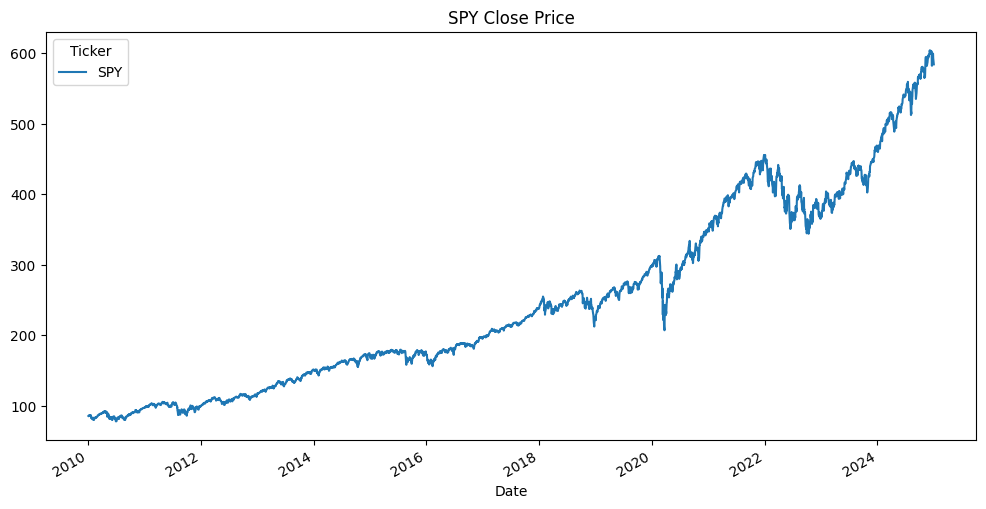

In [ ]:
# Get SYP CLOSING data using slicing
spy_data['Close'].plot(title='SPY Close Price', figsize=(12, 6))

In [49]:
# 80% training, 20% testing
spy_train_size = int(len(spy_data) * 0.8)  

spy_train_data = spy_data.iloc[:spy_train_size]  # First 80% for training 
spy_test_data = spy_data.iloc[spy_train_size:]  # Remaining 20% for testing

print(f"Training data: {spy_train_data.index[0]} to {spy_train_data.index[-1]}")
print(f"Testing data: {spy_test_data.index[0]} to {spy_test_data.index[-1]}")

Training data: 2010-01-04 00:00:00 to 2021-12-29 00:00:00
Testing data: 2021-12-30 00:00:00 to 2024-12-31 00:00:00


# **Evaluate Training Data**

[DEBUG] Step=1 | Profit=-0.0032, Sharpe=0.0000, Growth=0.0000, TradeReward=0.0000, Dir=0.5000, Crash=0.0000, Penalty=0.0124, Total Reward=0.4844

📊 Evaluation Metrics for Trading All Stocks:
Initial Investment: 20000.00
Final Value: 42364.55
Profit: 22364.55
Return (%): 111.82
Sharpe Ratio: 0.46
Max Drawdown (%): 34.51
Total Trades: 25447.00
Trade logs saved to trading_history.csv


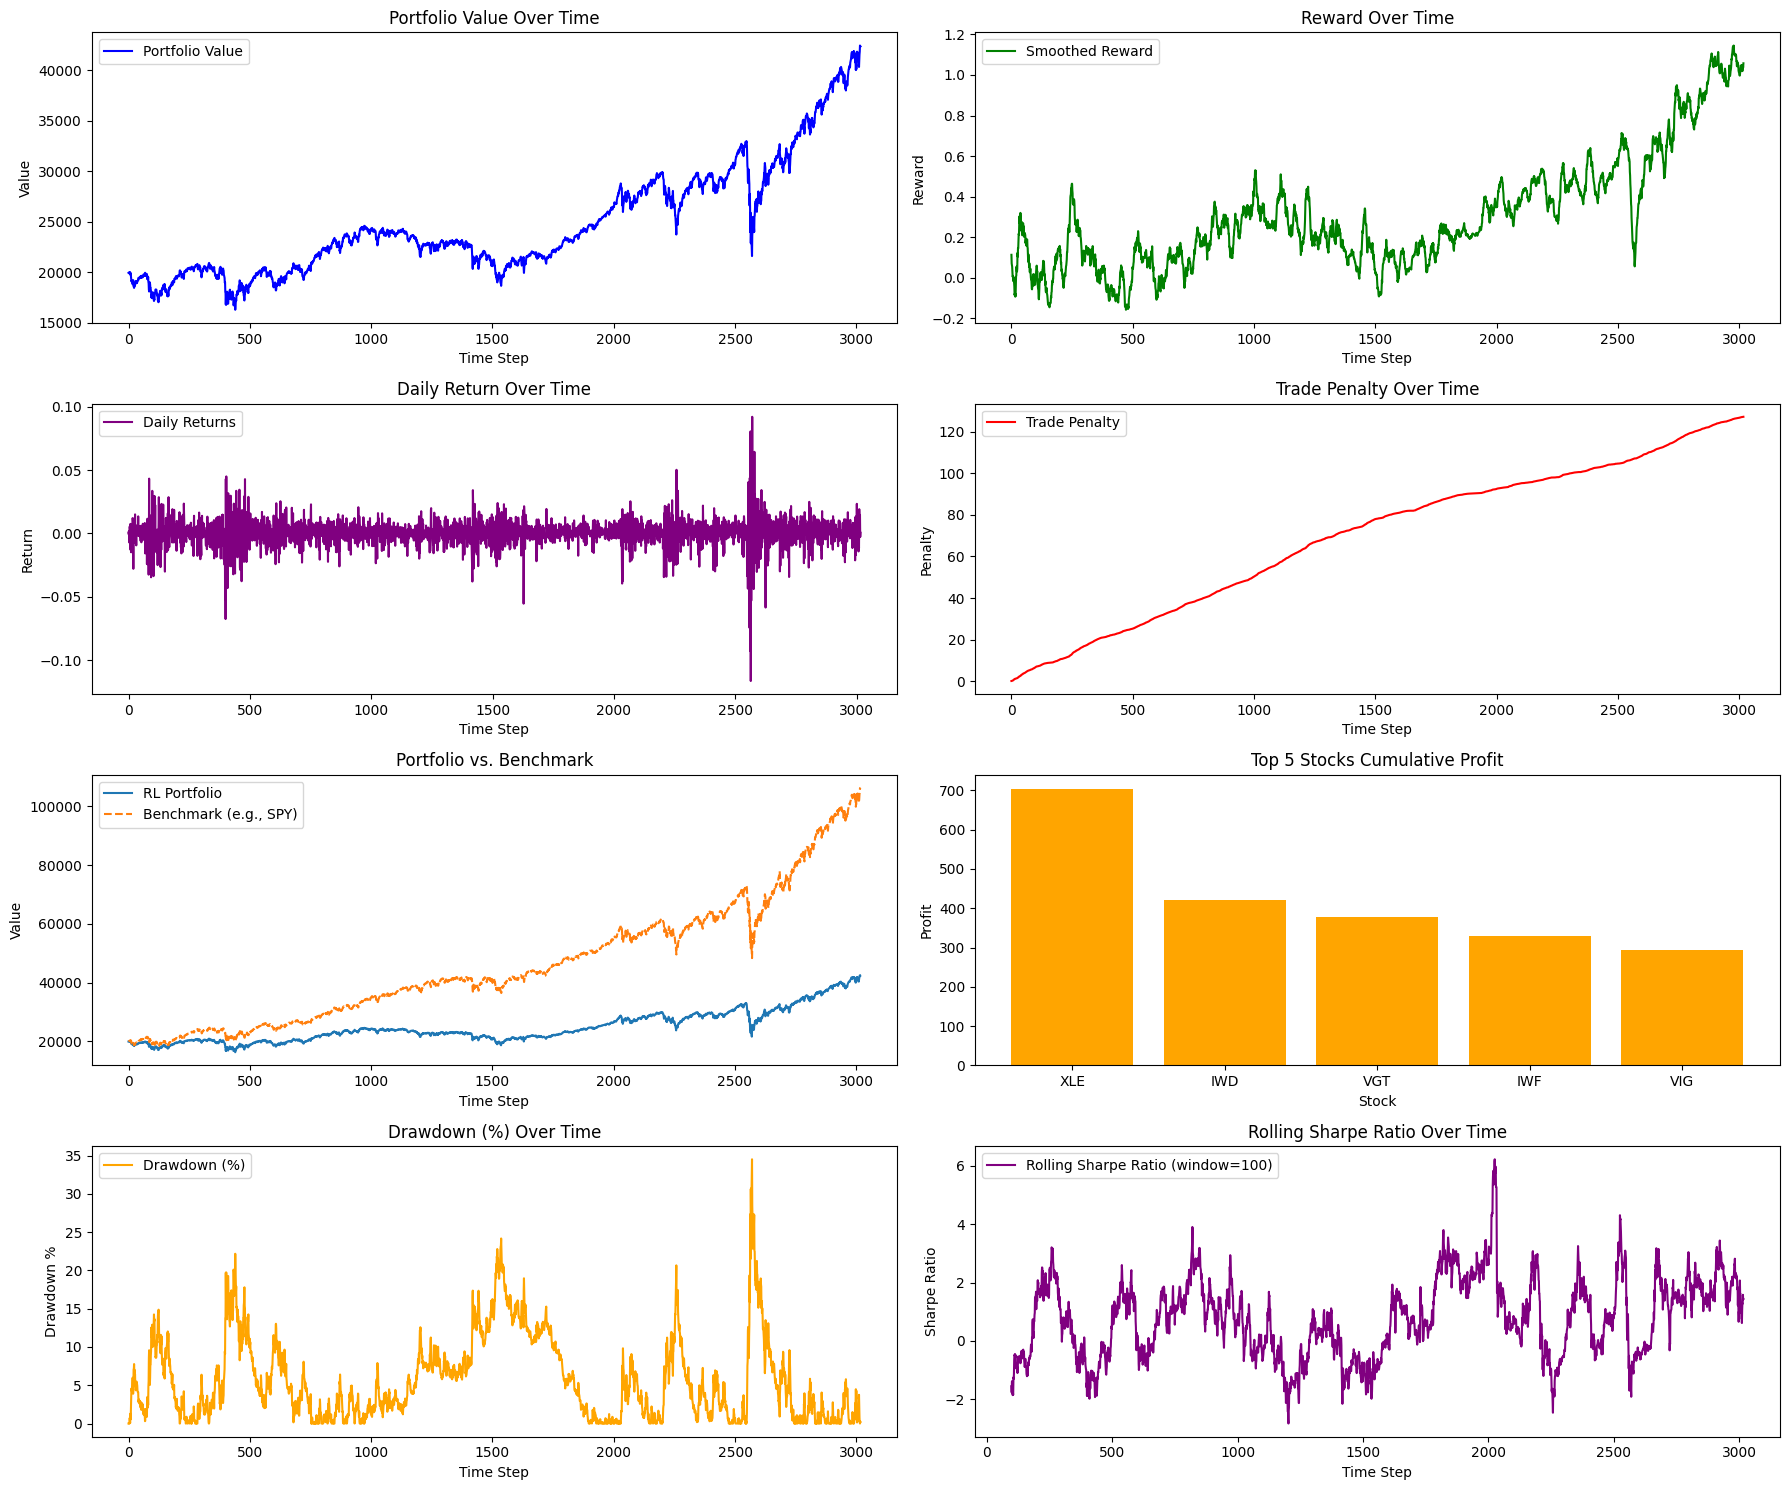

In [ ]:
# Evaluate usage
benchmark_data= spy_train_data['Close'].values  # Use the closing prices for evaluation
train_benchmark_normalized = benchmark_data / benchmark_data[0] * 20000

# Create the environment for evaluation
train_metrics, train_rewards, train_portfolio_values = evaluate_trading_bot(model, train_env, benchmark_data=train_benchmark_normalized)


# **Evaluate Test Data**

[DEBUG] Step=1 | Profit=-0.0063, Sharpe=0.0000, Growth=0.0000, TradeReward=0.0000, Dir=0.2800, Crash=0.0000, Penalty=0.0128, Total Reward=0.2608

📊 Evaluation Metrics for Trading All Stocks:
Initial Investment: 20000.00
Final Value: 24804.82
Profit: 4804.82
Return (%): 24.02
Sharpe Ratio: 0.53
Max Drawdown (%): 21.26
Total Trades: 3120.00
Trade logs saved to trading_history.csv


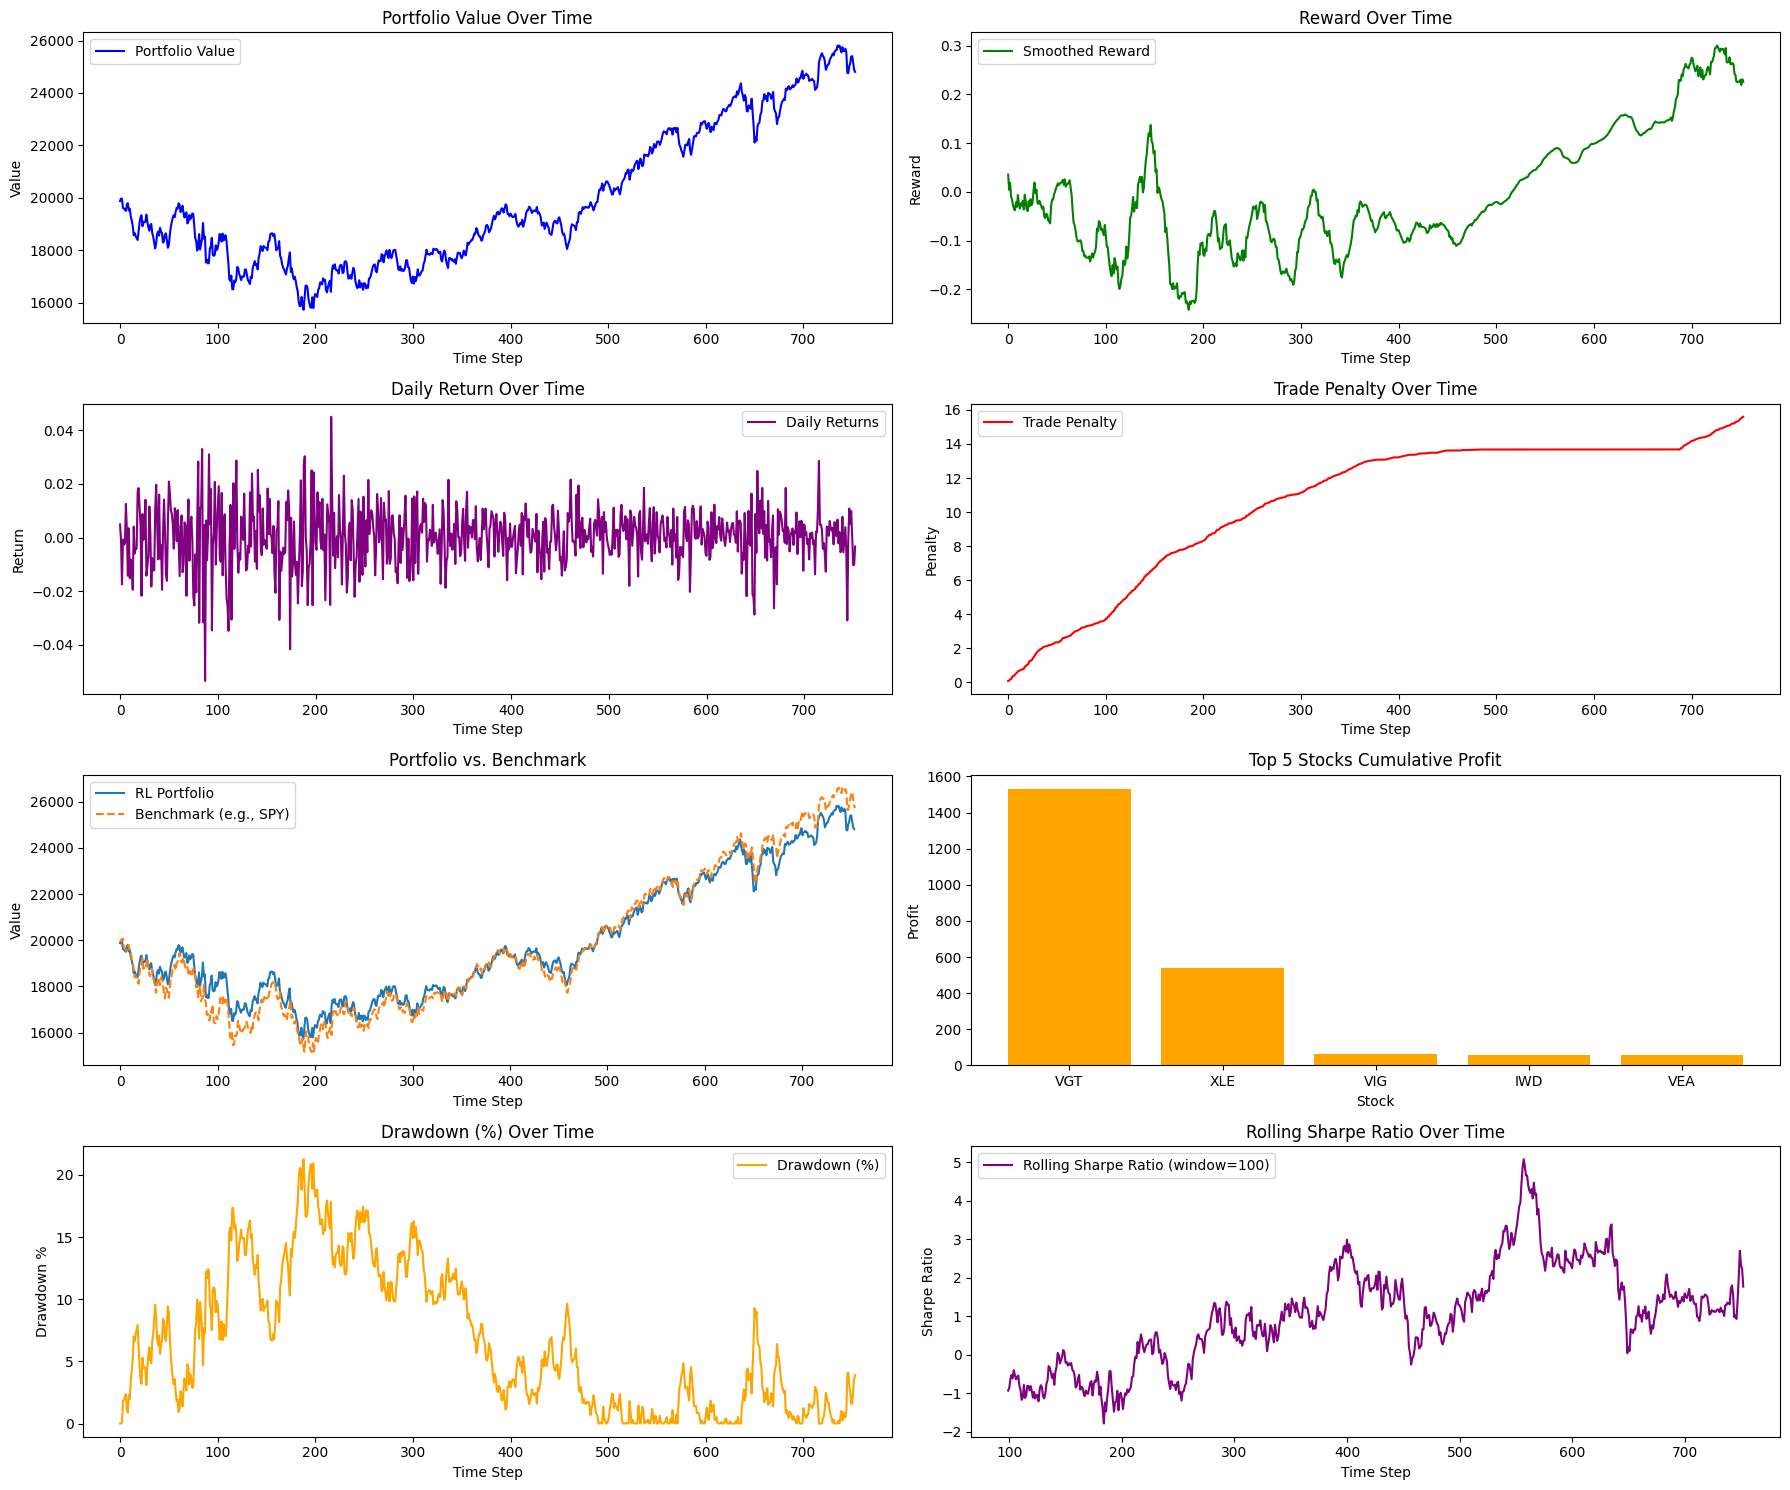

In [51]:
# Evaluate usage
benchmark_data= spy_test_data['Close'].values  # Use the closing prices for evaluation
test_benchmark_normalized = benchmark_data / benchmark_data[0] * 20000
# Create the environment for evaluation
#metrics = evaluate_trading_bot(model, test_env, benchmark_data=test_benchmark_normalized)
test_metrics, test_rewards, test_portfolio_values = evaluate_trading_bot(model, test_env, benchmark_data=test_benchmark_normalized)


# **Performance Evalution**

In [ ]:
def plot_train_vs_test_rewards(train_rewards, test_rewards):
    plt.figure(figsize=(10,6))
    plt.plot(smooth_series(train_rewards, window=20), label='Train Rewards')
    plt.plot(smooth_series(test_rewards, window=20), label='Test Rewards', linestyle='--')
    plt.title('Training vs Testing Rewards')
    plt.xlabel('Time Step')
    plt.ylabel('Reward')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


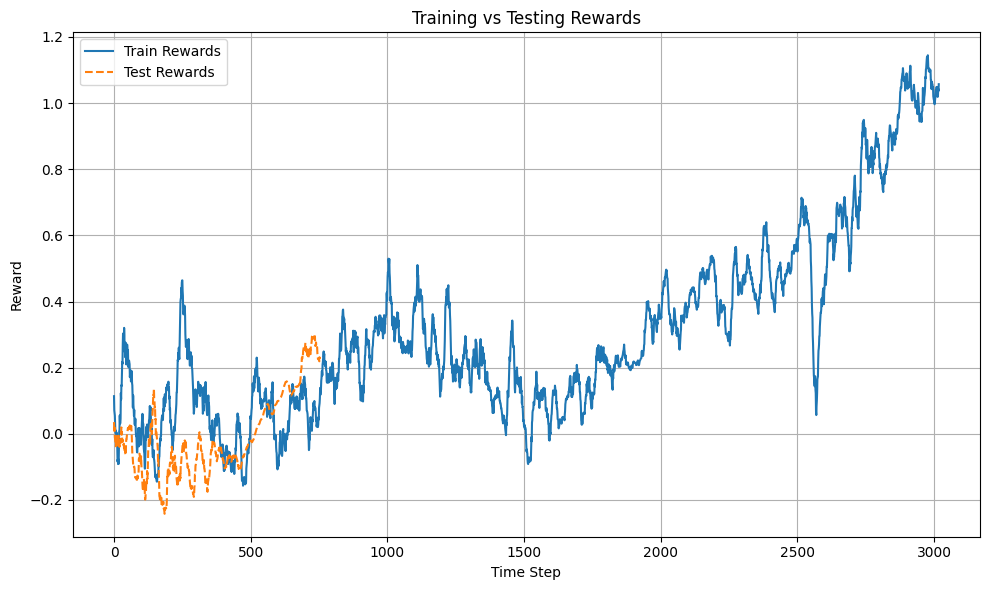

In [ ]:
plot_train_vs_test_rewards(train_rewards, test_rewards)


In [ ]:
trade_logs = pd.read_csv('trading_history.csv')
trade_logs.head()

,Stock_Ticker,Trade_Type,Quantity,Price,Date,Profit_Loss,Holding_Period
0,VTI,Buy,8,230.682037,2021-12-30,0.0,0.0
1,VEA,Buy,43,46.238430,2021-12-30,0.0,0.0
2,VUG,Buy,6,316.305084,2021-12-30,0.0,0.0
3,IWF,Buy,6,300.462433,2021-12-30,0.0,0.0
4,IJH,Buy,37,53.869583,2021-12-30,0.0,0.0


In [ ]:
# Group by Stock_Ticker and sum Profit_Loss
stock_profit = trade_logs.groupby('Stock_Ticker')['Profit_Loss'].sum().sort_values(ascending=False)

# Get Top 5 profitable stocks
top5_stocks = stock_profit.head(5)
print("Top 5 Performing Stocks:\n", top5_stocks)


Top 5 Performing Stocks:
 Stock_Ticker
VGT    1532.26
XLE     541.57
VIG      61.34
IWD      60.39
VEA      58.56
Name: Profit_Loss, dtype: float64


In [ ]:
def plot_top5_stock_performance(trade_logs, stock_data, top5_stocks, initial_investment=10000):
    plt.figure(figsize=(12, 6))

    # Normalize benchmark for comparison (e.g., SPY)
    spy_close = stock_data[('SPY', 'Close', 'SPY')]
    spy_normalized = spy_close / spy_close.iloc[0] * initial_investment
    plt.plot(spy_normalized, label='SPY Benchmark', linestyle='--', linewidth=2)

    # Plot each top stock
    for ticker in top5_stocks.index:
        try:
            close_prices = stock_data[(ticker, 'Close', ticker)]
            normalized = close_prices / close_prices.iloc[0] * initial_investment
            plt.plot(normalized, label=f"{ticker} (PL: {top5_stocks[ticker]:.2f})")
        except KeyError:
            print(f"{ticker} not found in stock_data, skipping.")

    plt.title("Testing Set - Top 5 Performing Stocks vs Benchmark")
    plt.xlabel("Date")
    plt.ylabel("Normalized Value")
    plt.legend()
    plt.tight_layout()
    plt.grid(True)
    plt.show()


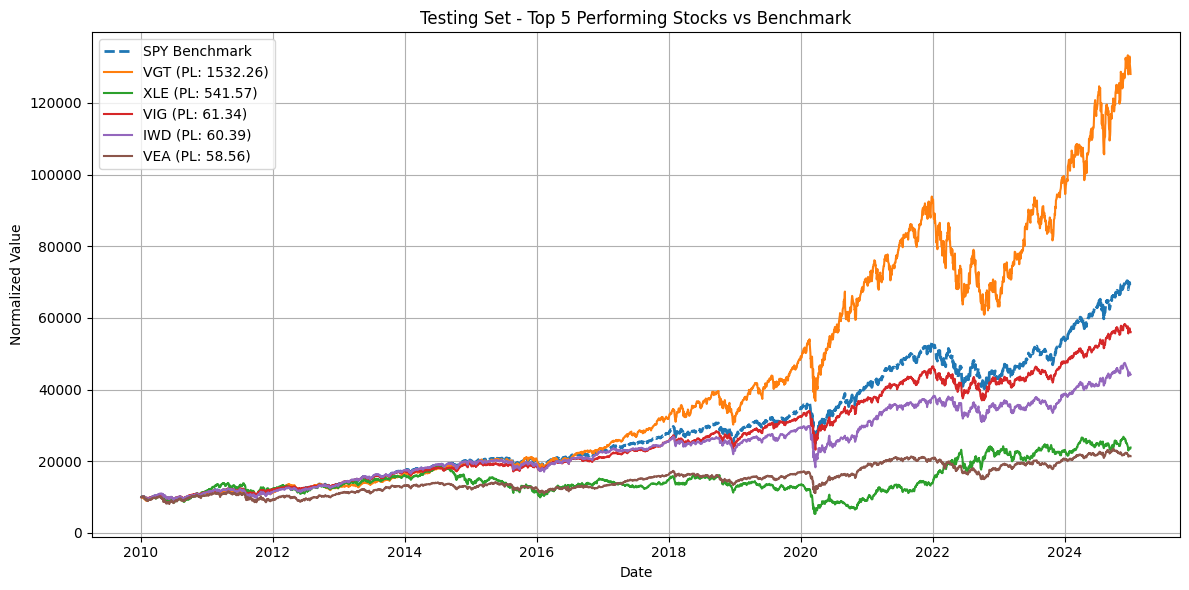

In [ ]:
plot_top5_stock_performance(trade_logs, stock_data, top5_stocks)
